In [152]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import ComplementNB
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# data

In [2]:
df = pd.read_csv('Processed_data/clean_data.csv',index_col=0)
diag = pd.read_csv('Data/claim_diagnoses.csv',index_col=0)

In [5]:
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at,label,unit_price
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30,0,302.68
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19,0,302.68
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,23.00
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,126.50
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,9.20


In [3]:
diag.head()

,id,claim_id,diagnosis_id
0,15,10,9
1,16,11,15925
2,36,13,4342
3,37,14,15925
4,38,15,6190


In [6]:
dfmerge = df.merge(diag, how = 'left', left_on = 'claim_id', right_on = 'claim_id')
dfmerge.shape

(663623, 17)

In [53]:
dfmerge.to_csv('Processed_data/full_clean_data.csv')

In [7]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663623 entries, 0 to 663622
Data columns (total 17 columns):
claim_id           663623 non-null float64
enrollee_id        663623 non-null float64
provider_id        663623 non-null float64
provider_status    663623 non-null float64
hmo_id             663623 non-null float64
care_id            663623 non-null float64
qty                663623 non-null float64
amount             663623 non-null float64
approved_qty       663623 non-null float64
approved_amount    663623 non-null float64
hmo_approved       663623 non-null float64
created_at         663623 non-null object
vetted_at          663623 non-null object
label              663623 non-null int64
unit_price         663623 non-null float64
id                 663615 non-null float64
diagnosis_id       663615 non-null float64
dtypes: float64(14), int64(1), object(2)
memory usage: 91.1+ MB


In [177]:
dfmerge.shape

(663623, 17)

In [199]:
df.loc[df['label'] == 0]['amount'].sum(),df.loc[df['label'] == 1]['amount'].sum()

(1058638193.4299998, 113948584.74)

In [202]:
df.loc[df['label']==1]['claim_id'].count(),df.loc[df['label']==0]['claim_id'].count()


(13914, 268137)

In [9]:
X = dfmerge[['enrollee_id','diagnosis_id','provider_id','provider_status','hmo_id','care_id','qty','unit_price']]
y = dfmerge['label']

(694362.5539434494, 663615, 0.044281699479366804)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663623 entries, 0 to 663622
Data columns (total 8 columns):
enrollee_id        663623 non-null float64
diagnosis_id       663615 non-null float64
provider_id        663623 non-null float64
provider_status    663623 non-null float64
hmo_id             663623 non-null float64
care_id            663623 non-null float64
qty                663623 non-null float64
unit_price         663623 non-null float64
dtypes: float64(8)
memory usage: 45.6 MB


In [11]:
X.diagnosis_id.min(),X.diagnosis_id.max()

(2.0, 104275.0)

In [14]:
dropindex = X.loc[X.diagnosis_id.isnull()].index
X.iloc[dropindex]

,enrollee_id,diagnosis_id,provider_id,provider_status,hmo_id,care_id,qty,unit_price
298716,2.0,NaN,302.0,1.0,1.0,44.0,8.0,5000.0
338641,107111.0,NaN,83.0,1.0,1.0,15615.0,1.0,5000.0
338642,107111.0,NaN,83.0,1.0,1.0,15614.0,1.0,1000.0
339085,107111.0,NaN,83.0,1.0,1.0,15613.0,1.0,15000.0
339213,107111.0,NaN,83.0,1.0,1.0,15717.0,1.0,15000.0
339988,107111.0,NaN,83.0,1.0,1.0,15614.0,1.0,1000.0
340175,113273.0,NaN,83.0,1.0,1.0,12529.0,30.0,60.0
340176,113273.0,NaN,83.0,1.0,1.0,15717.0,1.0,15000.0


In [15]:
X.drop(dropindex, axis=0, inplace = True)
y.drop(dropindex, axis=0, inplace = True)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [168]:
def init_scores():
     
    scores = {}
    scores['f1_socre'] = []
    scores['precision'] = []
    scores['recall'] = []
    scores['FPR'] = []
    scores['specificity'] = []
    scores['roc_auc'] = []
    
    return scores


def evaluation(ytest,Xtest,cls):

    scores = init_scores()
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))
    
    return scores
      
def cv(Xtrain,ytrain,model):
    
    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        scores = evaluation(yte,Xte,cls)
        n += 1
        
    
    print('\n mean scores +/- sd: \n')
    for k in scores:
        print('{} : {:0.3f} +/- {:0.3f}'.format(k, np.array(scores[k]).mean(),  np.array(scores[k]).std()))

    return models, scores

In [36]:

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)


# 3 models without upsampling and without class weight

In [41]:
# nb
print('nb:')
model_nb = ComplementNB()
models_nb, scores_nb = cv(Xtrain.values,ytrain.values,model_nb)


# xgb

print('xgb:')
model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_xgb, scores_xgb = cv(Xtrain.values,ytrain.values,model_xgb)


# lgb
print('lgb:')
model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=100, max_depth=15, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:1}, \
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split')
models_lgb, scores_lgb = cv(Xtrain.values,ytrain.values,model_lgb)

nb:
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.098
precision: 0.059
recall/sensitivity(true positive rate): 0.298
false positive rate (FPR): 0.224
spcificity(true negative rate): 0.776
ROC_AUC_score: 0.537
cross_validate_run: 1
f1_socre: 0.099
precision: 0.059
recall/sensitivity(true positive rate): 0.312
false positive rate (FPR): 0.226
spcificity(true negative rate): 0.774
ROC_AUC_score: 0.543
cross_validate_run: 2
f1_socre: 0.099
precision: 0.059
recall/sensitivity(true positive rate): 0.309
false positive rate (FPR): 0.227
spcificity(true negative rate): 0.773
ROC_AUC_score: 0.541
cross_validate_run: 3
f1_socre: 0.097
precision: 0.058
recall/sensitivity(true positive rate): 0.295
false positive rate (FPR): 0.224
spcificity(true negative rate): 0.776
ROC_AUC_score: 0.535

 mean scores +/- sd: 

f1_socre : 0.097 +/- 0.000
precision : 0.058 +/- 0.000
recall : 0.295 +/- 0.000
FPR : 0.224 +/- 0.000
specificity : 0.776 +/- 0.00

In [42]:
test_scores_nb = evaluation(ytest.values,Xtest.values,models_nb[0])
test_scores_xgb = evaluation(ytest.values,Xtest.values,models_xgb[0])
test_scores_lgb = evaluation(ytest.values,Xtest.values,models_lgb[0])

f1_socre: 0.101
precision: 0.060
recall/sensitivity(true positive rate): 0.307
false positive rate (FPR): 0.224
spcificity(true negative rate): 0.776
ROC_AUC_score: 0.542
f1_socre: 0.480
precision: 0.774
recall/sensitivity(true positive rate): 0.348
false positive rate (FPR): 0.005
spcificity(true negative rate): 0.995
ROC_AUC_score: 0.672
f1_socre: 0.303
precision: 0.810
recall/sensitivity(true positive rate): 0.186
false positive rate (FPR): 0.002
spcificity(true negative rate): 0.998
ROC_AUC_score: 0.592


In [43]:

pickle.dump(models_nb[0],open("Models/no_upsample/nb.dat", "wb"))
pickle.dump(models_xgb[0],open("Models/no_upsample/xgb.dat", "wb"))
pickle.dump(models_lgb[0],open("Models/no_upsample/lgb.dat", "wb"))

# 2 models without upsampling but with class weight

In [55]:
# xgb

print('xgb:')
model_xgb_w = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, seed=None,
              silent=None, subsample=1, verbosity=1)
models_xgb_w, scores_xgb_w = cv(Xtrain.values,ytrain.values,model_xgb_w)


# lgb
print('lgb:')
model_lgb_w = LGBMClassifier(boosting_type='gbdt', num_leaves=100, max_depth=15, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:50}, \
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                       random_state=None, n_jobs=4, silent=True, importance_type='split')
models_lgb_w, scores_lgb_w = cv(Xtrain.values,ytrain.values,model_lgb_w)

xgb:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.511
precision: 0.395
recall/sensitivity(true positive rate): 0.725
false positive rate (FPR): 0.052
spcificity(true negative rate): 0.948
ROC_AUC_score: 0.837
cross_validate_run: 1
f1_socre: 0.511
precision: 0.390
recall/sensitivity(true positive rate): 0.738
false positive rate (FPR): 0.053
spcificity(true negative rate): 0.947
ROC_AUC_score: 0.843
cross_validate_run: 2
f1_socre: 0.516
precision: 0.398
recall/sensitivity(true positive rate): 0.736
false positive rate (FPR): 0.051
spc

In [56]:
test_scores_xgb_w = evaluation(ytest.values,Xtest.values,models_xgb_w[0])
test_scores_lgb_w = evaluation(ytest.values,Xtest.values,models_lgb_w[0])

f1_socre: 0.510
precision: 0.392
recall/sensitivity(true positive rate): 0.731
false positive rate (FPR): 0.053
spcificity(true negative rate): 0.947
ROC_AUC_score: 0.839
f1_socre: 0.254
precision: 0.148
recall/sensitivity(true positive rate): 0.897
false positive rate (FPR): 0.241
spcificity(true negative rate): 0.759
ROC_AUC_score: 0.828


In [57]:
pickle.dump(models_xgb[0],open("Models/no_upsample/xgb_w50.dat", "wb"))
pickle.dump(models_lgb[0],open("Models/no_upsample/lgb_w50.dat", "wb"))

# upsampling training data but not testing data

In [44]:
Xytrain = Xtrain.copy()
Xytrain['y'] = ytrain.copy()

class0 = Xytrain.loc[Xytrain.y == 0] # majority
class1 = Xytrain.loc[Xytrain.y == 1] # 5%

class1 = class1.sample(n=class0.shape[0],replace=True,random_state=0) # upsampled
Xytrain_new = pd.concat([class0,class1])

ytrain_new = Xytrain_new['y']
Xtrain_new = Xytrain_new.drop(columns=['y'])

In [45]:
Xtrain_new.shape,ytrain_new.shape

((1014852, 8), (1014852,))

In [46]:
Xtrain_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014852 entries, 250744 to 575097
Data columns (total 8 columns):
enrollee_id        1014852 non-null float64
diagnosis_id       1014852 non-null float64
provider_id        1014852 non-null float64
provider_status    1014852 non-null float64
hmo_id             1014852 non-null float64
care_id            1014852 non-null float64
qty                1014852 non-null float64
unit_price         1014852 non-null float64
dtypes: float64(8)
memory usage: 69.7 MB


# 3 models upsampling training data and testing data

In [50]:

Xy = X.copy()
Xy['y'] = y

class0up = Xy.loc[Xy.y == 0]
class1up = Xy.loc[Xy.y == 1]

class1up = class1up.sample(n=class0up.shape[0],replace=True,random_state=0)
Xy = pd.concat([class0up,class1up])
yup = Xy['y']
Xup = Xy.drop(columns=['y'])
# re-do train_test split of balanced data
Xuptrain,Xuptest,yuptrain,yuptest = train_test_split(Xup.values,yup.values,test_size = 0.2,random_state=42)

In [51]:
# nb
print('nb_up_train:')
models_nb_utt, scores_nb_utt = cv(Xuptrain,yuptrain, model_nb)


# xgb
print('xgb:')

models_xgb_utt, scores_xgb_utt = cv(Xuptrain,yuptrain,model_xgb)


# lgb
print('lgb:')

models_lgb_utt, scores_lgb_utt = cv(Xuptrain,yuptrain,model_lgb)

nb_up_train:
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.395
precision: 0.574
recall/sensitivity(true positive rate): 0.302
false positive rate (FPR): 0.223
spcificity(true negative rate): 0.777
ROC_AUC_score: 0.539
cross_validate_run: 1
f1_socre: 0.393
precision: 0.573
recall/sensitivity(true positive rate): 0.299
false positive rate (FPR): 0.222
spcificity(true negative rate): 0.778
ROC_AUC_score: 0.538
cross_validate_run: 2
f1_socre: 0.394
precision: 0.573
recall/sensitivity(true positive rate): 0.301
false positive rate (FPR): 0.225
spcificity(true negative rate): 0.775
ROC_AUC_score: 0.538
cross_validate_run: 3
f1_socre: 0.395
precision: 0.578
recall/sensitivity(true positive rate): 0.300
false positive rate (FPR): 0.220
spcificity(true negative rate): 0.780
ROC_AUC_score: 0.540

 mean scores +/- sd: 

f1_socre : 0.395 +/- 0.000
precision : 0.578 +/- 0.000
recall : 0.300 +/- 0.000
FPR : 0.220 +/- 0.000
specificity : 0.780

In [58]:
test_scores_xgb_utt = evaluation(ytest.values,Xtest.values,models_xgb_utt[0])
test_scores_lgb_utt = evaluation(ytest.values,Xtest.values,models_lgb_utt[0])

f1_socre: 0.696
precision: 0.534
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.041
spcificity(true negative rate): 0.959
ROC_AUC_score: 0.979
f1_socre: 0.378
precision: 0.238
recall/sensitivity(true positive rate): 0.920
false positive rate (FPR): 0.138
spcificity(true negative rate): 0.862
ROC_AUC_score: 0.891


In [60]:
pickle.dump(models_xgb_utt[0],open("Models/upsample/xgb.dat", "wb"))
pickle.dump(models_lgb_utt[0],open("Models/upsample/lgb.dat", "wb"))

# plot performance
## plot scores

In [61]:
# no upsampling, no weight
scores_nb, scores_xgb, scores_lgb

({'f1_socre': [0.09693438757109168],
  'precision': [0.05800517962680125],
  'recall': [0.29475282605027836],
  'FPR': [0.22375311524022845],
  'specificity': [0.7762468847597715],
  'roc_auc': [0.535499855405025]},
 {'f1_socre': [0.46197382384152813],
  'precision': [0.7670321064996085],
  'recall': [0.33052134300658004],
  'FPR': [0.0046925770529038235],
  'specificity': [0.9953074229470962],
  'roc_auc': [0.6629143829768381]},
 {'f1_socre': [0.29869595058339055],
  'precision': [0.801178203240059],
  'recall': [0.18356672853045386],
  'FPR': [0.002129404713082428],
  'specificity': [0.9978705952869176],
  'roc_auc': [0.5907186619086857]})

In [63]:
# no upsampling, with weight
scores_xgb_w, scores_lgb_w

({'f1_socre': [0.5146886016451234],
  'precision': [0.3948435950599477],
  'recall': [0.7389910578707609],
  'FPR': [0.052943310514527275],
  'specificity': [0.9470566894854727],
  'roc_auc': [0.8430238736781168]},
 {'f1_socre': [0.2546476437527021],
  'precision': [0.14845828549024],
  'recall': [0.894381643327147],
  'FPR': [0.23980251742957193],
  'specificity': [0.7601974825704281],
  'roc_auc': [0.8272895629487875]})

In [64]:
# upsampling, without weight
scores_nb_utt, scores_xgb_utt, scores_lgb_utt

({'f1_socre': [0.3951383206802623],
  'precision': [0.5775029517725773],
  'recall': [0.3003069899244333],
  'FPR': [0.22037725718707313],
  'specificity': [0.7796227428129269],
  'roc_auc': [0.5399648663686801]},
 {'f1_socre': [0.9747244678683595],
  'precision': [0.9525594884779816],
  'recall': [0.9979455289672544],
  'FPR': [0.049853534516111186],
  'specificity': [0.9501464654838888],
  'roc_auc': [0.9740459972255716]},
 {'f1_socre': [0.8875451402228199],
  'precision': [0.8668317574666067],
  'recall': [0.909272670025189],
  'FPR': [0.1401173303013794],
  'specificity': [0.8598826696986206],
  'roc_auc': [0.8845776698619048]})

In [170]:
nb = [scores_nb[k][0] for k in scores_nb]
xgb = [scores_xgb[k][0] for k in scores_xgb]
lgb = [scores_lgb[k][0] for k in scores_lgb]

xgb_w = [scores_xgb_w[k][0] for k in scores_xgb_w]
lgb_w = [scores_lgb_w[k][0] for k in scores_lgb_w]

nb_utt = [scores_nb_utt[k][0] for k in scores_nb_utt]
xgb_utt = [scores_xgb_utt[k][0] for k in scores_xgb_utt]
lgb_utt = [scores_lgb_utt[k][0] for k in scores_lgb_utt]

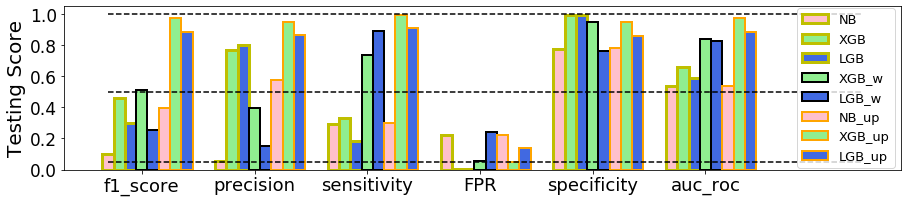

In [175]:
fig = plt.figure(figsize=(15,3))
w = 0.1
x = np.array([0,1,2,3,4,5])

plt.bar(x,nb, label = 'NB',color = 'pink',width=w, edgecolor = 'y',linewidth=3)
plt.bar(x+w, xgb, label = 'XGB',color = 'lightgreen',width=w,edgecolor = 'y',linewidth=3)
plt.bar(x+2*w, lgb, label = 'LGB',color = 'royalblue',width=w,edgecolor = 'y',linewidth=3)

plt.bar(x+3*w, xgb_w, label = 'XGB_w',color = 'lightgreen',width=w,edgecolor = 'black',linewidth=2)
plt.bar(x+4*w, lgb_w,label = 'LGB_w',color='royalblue',width=w,edgecolor = 'black',linewidth=2)

plt.bar(x+5*w, nb_utt,label = 'NB_up',color='pink',width=w,edgecolor = 'orange',linewidth=2)
plt.bar(x+6*w, xgb_utt,label = 'XGB_up',color='lightgreen',width=w,edgecolor = 'orange',linewidth=2)
plt.bar(x+7*w, lgb_utt,label = 'LGB_up',color='royalblue',width=w,edgecolor = 'orange',linewidth=2)
plt.hlines(1,0,6+7*w,linestyles='dashed')
plt.hlines(0.5,0,6+7*w,linestyles='dashed')
plt.hlines(0.05,0,6+7*w,linestyles='dashed')
plt.xticks(x+3*w,['f1_score','precision','sensitivity','FPR','specificity','auc_roc'],fontsize=18)
plt.yticks(fontsize=17)
plt.ylabel('Testing Score',fontsize=20)
plt.legend(bbox_to_anchor=(1, 1.03), fontsize=13)#prop=dict(weight='bold')

## plot ROC_curves

In [141]:
model_xgb = pickle.load(open("Models/no_upsample/xgb.dat", "rb"))
model_nb = pickle.load(open("Models/no_upsample/nb.dat", "rb"))
model_lgb = pickle.load(open("Models/no_upsample/lgb.dat", "rb"))

In [142]:
xbg_curve = roc_curve(yuptest,model_xgb.predict_proba(Xuptest)[:,1])
nb_curve = roc_curve(yuptest,model_nb.predict_proba(Xuptest)[:,1])
lgb_curve = roc_curve(yuptest,model_lgb.predict_proba(Xuptest)[:,1])

In [94]:
def plot_roc_curves(curves,colors,labels):
    plt.plot([0,0.5,1],[0,0.5,1], linestyle='--', color = 'black') # default classification bound
    
    for i in range(len(curves)):
        fpr, tpr, _ = curves[i]
        plt.plot(fpr,tpr,color=colors[i],linewidth=2,label=labels[i])
    
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    plt.show()
    

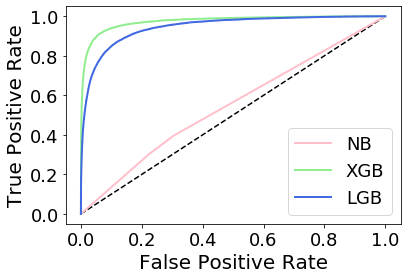

In [143]:
plot_roc_curves([nb_curve,xbg_curve,lgb_curve],['pink','lightgreen','royalblue'],['NB','XGB','LGB'])

## parameter tiltering

In [161]:
cls5 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_cls5, scores_cls5 = cv(Xuptrain,yuptrain,cls5)

cls10 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_cls10, scores_cls10 = cv(Xuptrain,yuptrain,cls10)

cls_w = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, verbosity=1)
models_cls_w, scores_cls_w = cv(Xuptrain,yuptrain,cls_w)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.800
precision: 0.800
recall/sensitivity(true positive rate): 0.801
false positive rate (FPR): 0.200
spcificity(true negative rate): 0.800
ROC_AUC_score: 0.800
cross_validate_run: 1
f1_socre: 0.804
precision: 0.802
recall/sensitivity(true positive rate): 0.806
false positive rate (FPR): 0.199
spcificity(true negative rate): 0.801
ROC_AUC_score: 0.804
cross_validate_run: 2
f1_socre: 0.804
precision: 0.803
recall/sensitivity(true positive rate): 0.805
false positive rate (FPR): 0.198
spcificity

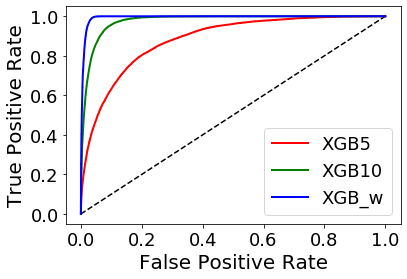

In [165]:
plot_roc_curves([xgb5,xgb10,xgb_w],['red','green','blue'],['XGB5','XGB10','XGB_w'])

In [132]:
xgb = roc_curve(yuptest,pickle.load(open("Models/no_upsample/xgb.dat", "rb")).predict_proba(Xuptest)[:,1])

In [138]:
xgb_w = roc_curve(yuptest,pickle.load(open("Models/no_upsample/xgb_w50.dat", "rb")).predict_proba(Xuptest)[:,1])

In [134]:
xgb_up = roc_curve(yuptest,pickle.load(open("Models/upsample/xgb.dat", "rb")).predict_proba(Xuptest)[:,1])

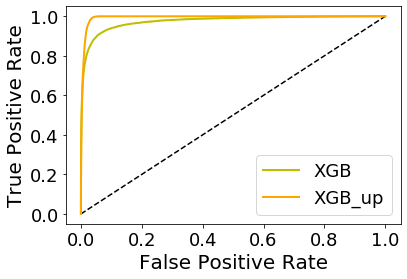

In [140]:
plot_roc_curves([xgb,xgb_up],['y','orange'],['XGB','XGB_up'])

## plot feature importance

In [147]:
best = pickle.load(open("Models/upsample/xgb.dat", "rb"))

In [145]:
X.columns

Index(['enrollee_id', 'diagnosis_id', 'provider_id', 'provider_status',
       'hmo_id', 'care_id', 'qty', 'unit_price'],
      dtype='object')

In [158]:
columns = ['enrollee', 'diagnosis', 'provider', 'provider_status',\
       'hmo_id', 'care', 'qty', 'care_bill']

In [153]:
def feature_importance(model,columns):
    # Plot importance for beset model: model_mse
    fig, ax = plt.subplots(figsize=(15,5))

    g1 = xgboost.plot_importance(model,ax=ax,grid=False)

    oldy = g1.yaxis.get_majorticklabels()
    feature_dict = dict(zip(['f'+str(i) for i in range(len(columns))], columns))
    newy = [feature_dict[y._text] for y in oldy]
    g1.set_yticklabels(newy,rotation=0,fontsize=14)

    fig.savefig('feature_importance.jpg')
    plt.title('Feature Importance',fontsize=20)
    plt.xlabel('F score',fontsize = 18)
    plt.ylabel('Features', fontsize = 18)
    plt.show()

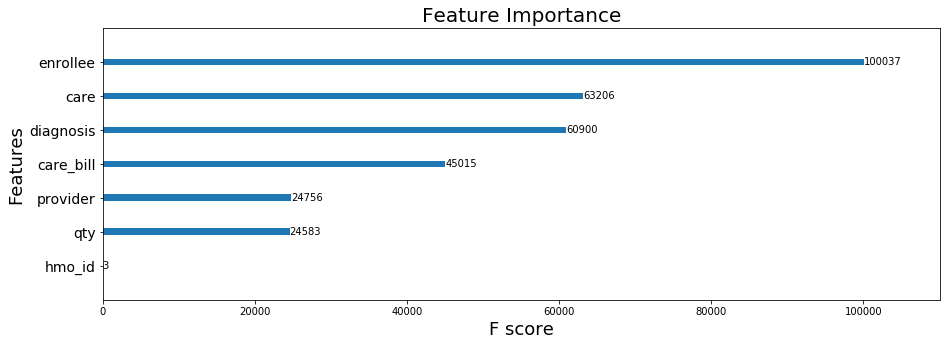

In [159]:
feature_importance(best,columns)